In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# %load_ext cudf.pandas
# import pandas as pd
# print(pd)


In [3]:
# Optimizations
# GDAL optimizations
import multiprocessing as mp
import os

cpu_count: int = mp.cpu_count()
num_cores: int = cpu_count - 2
os.environ["GDAL_NUM_THREADS"] = f"{num_cores}"
os.environ["GDAL_CACHEMAX"] = "1024"


## Libraries

In [4]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import riskmapjnr as rmj


## Set user parameters

In [6]:
project_name = "test"


In [7]:
forest_source = "gfc"  ##gfc, tmf
tree_cover_threshold = 10
years = [2015, 2020, 2024]
string_years = [str(num) for num in years]


## Connect folders

In [5]:
root_folder: Path = Path.cwd().parent
downloads_folder: Path = root_folder / "data"
downloads_folder.mkdir(parents=True, exist_ok=True)


In [8]:
project_folder = downloads_folder / project_name
project_folder.mkdir(parents=True, exist_ok=True)
processed_data_folder = project_folder / "data"
processed_data_folder.mkdir(parents=True, exist_ok=True)
plots_folder = project_folder / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)
rmj_bm = project_folder / "rmj_bm"
rmj_bm.mkdir(parents=True, exist_ok=True)


## Forest Files

In [9]:
def list_files_by_extension(folder_path, file_extensions):
    """
    List all files with specified extensions in the given folder.

    Parameters:
    folder_path (str): The path to the folder where you want to search for files.
    file_extensions (list of str): A list of file extensions to search for (e.g., ['.shp', '.tif']).

    Returns:
    list: A list of file paths with the specified extensions.
    """
    matching_files = []
    try:
        # Check if the provided path is a directory
        if os.path.isdir(folder_path):
            # Iterate over all files in the directory
            for filename in os.listdir(folder_path):
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
                # Check if the file has any of the specified extensions
                if any(filename.lower().endswith(ext) for ext in file_extensions):
                    matching_files.append(file_path)
        else:
            print(f"The provided path '{folder_path}' is not a directory.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return matching_files


In [10]:
def filter_files(input_files, filter_words, exclude_words=None):
    """
    Filters a list of files based on include and exclude words.

    Parameters:
        input_files (list): List of file paths to be filtered.
        filter_words (list): Words that must be present in the filenames for inclusion.
        exclude_words (list, optional): Words that must not be present in the filenames for exclusion.
        Defaults to None.

    Returns:
        list: Filtered list of files.
    """
    # Ensure all words are lowercase for case-insensitive comparison
    filter_words = [word.lower() for word in filter_words]
    exclude_words = [word.lower() for word in (exclude_words or [])]

    filtered_files = [
        file
        for file in input_files
        if all(word in os.path.basename(file).lower() for word in filter_words)
        and not any(
            exclude_word in os.path.basename(file).lower()
            for exclude_word in exclude_words
        )
    ]

    return filtered_files


In [11]:
# List all raster files in the processed data folder
input_raster_files = list_files_by_extension(processed_data_folder, [".tiff", ".tif"])


In [12]:
forest_change_file = filter_files(
    input_raster_files,
    ["forest", "loss", forest_source] + string_years,
    ["distance", "edge"],
)[0]


In [13]:
forest_yearly_files = filter_files(
    input_raster_files, ["forest", forest_source], ["loss", "edge"]
)


In [14]:
forest_edge_files = filter_files(input_raster_files, ["forest", forest_source, "edge"])


In [15]:
raster_subj_file = filter_files(input_raster_files, ["subj"])[0]


## Periods dictionaries

In [16]:
calibration_dict = {
    "period": "calibration",
    "train_period": "calibration",
    "initial_year": years[0],
    "final_year": years[1],
    "defor_value": 1,
    "time_interval": years[1] - years[0],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[0])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[0])])[0],
}
validation_dict = {
    "period": "validation",
    "train_period": "calibration",
    "initial_year": years[1],
    "final_year": years[2],
    "defor_value": 1,
    "time_interval": years[2] - years[1],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[1])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[1])])[0],
}
historical_dict = {
    "period": "historical",
    "train_period": "historical",
    "initial_year": years[0],
    "final_year": years[2],
    "defor_value": [1, 2],
    "time_interval": years[2] - years[0],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[0])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[0])])[0],
}
forecast_dict = {
    "period": "forecast",
    "train_period": "historical",
    "initial_year": years[0],
    "final_year": years[2],
    "defor_value": [1, 2],
    "time_interval": years[2] - years[0],
    "initial_year_forest": filter_files(forest_yearly_files, [str(years[2])])[0],
    "initial_year_forest_edge": filter_files(forest_edge_files, [str(years[2])])[0],
}


## 1 Calculate distance to forest edge

In [17]:
deforestation_thresh = 99.5
deforestation_thresh = 99.5
max_dist1 = 5000
max_dist2 = 5000


In [18]:
def calculate_period_dist_edge_threshold(
    forest_change_file,
    period_dictionary,
    deforestation_thresh,
    max_dist,
    model_folder,
    plots_folder,
):
    period_output_folder = model_folder / period_dictionary["period"]
    if not os.path.exists(period_output_folder):
        os.makedirs(period_output_folder)
    dist_thresh = rmj.dist_edge_threshold(
        fcc_file=forest_change_file,
        defor_values=period_dictionary["defor_value"],
        defor_threshold=deforestation_thresh,
        dist_file=period_dictionary["initial_year_forest_edge"],
        dist_bins=np.arange(0, max_dist, step=30),
        tab_file_dist=period_output_folder / "tab_dist.csv",
        fig_file_dist=plots_folder / f"perc_dist_{period_dictionary['period']}.png",
        blk_rows=128,
        dist_file_available=True,
        check_fcc=True,
        verbose=True,
    )
    # Save result
    dist_edge_data = pd.DataFrame(dist_thresh, index=[0])
    dist_edge_data.to_csv(
        period_output_folder / "dist_edge_threshold.csv",
        sep=",",
        header=True,
        index=False,
        index_label=False,
    )


In [19]:
calculate_period_dist_edge_threshold(
    forest_change_file,
    calibration_dict,
    deforestation_thresh,
    max_dist1,
    rmj_bm,
    plots_folder,
)


riskmapjnr: 0...10...20...30...40...50...60...70...80...90...100 - done
riskmapjnr: 0...10...20...30...40...50...60...70...80...90...100 - done


In [20]:
calculate_period_dist_edge_threshold(
    forest_change_file,
    historical_dict,
    deforestation_thresh,
    max_dist2,
    rmj_bm,
    plots_folder,
)


riskmapjnr: 0...10...20...30...40...50...60...70...80...90...100 - done
riskmapjnr: 0...10...20...30...40...50...60...70...80...90...100 - done


## 2 Compute bins

In [21]:
def get_dist_thresh(ifile):
    """Get distance to forest edge threshold."""
    dist_thresh_data = pd.read_csv(ifile)
    dist_thresh = dist_thresh_data.loc[0, "dist_thresh"]
    return dist_thresh


def save_dist_bins(dist_bins, output_file):
    dist_bins_str = [str(i) for i in dist_bins]
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("\n".join(dist_bins_str))


def get_dist_bins(dist_bins_file):
    """Get distance bins."""
    with open(dist_bins_file, "r", encoding="utf-8") as f:
        dist_bins = [float(line.rstrip()) for line in f]
    return dist_bins


In [22]:
def calculate_period_dist_bins(period_dictionary, model_folder):
    period_output_folder = model_folder / period_dictionary["period"]
    period_dist_edge_file = period_output_folder / "dist_edge_threshold.csv"
    dist_bins = rmj.benchmark.compute_dist_bins(
        period_dictionary.get("initial_year_forest_edge"),
        get_dist_thresh(period_dist_edge_file),
    )
    dist_thresh = get_dist_thresh(period_dist_edge_file)
    dist_bins_file = period_output_folder / "dist_bins.csv"
    save_dist_bins(dist_bins, dist_bins_file)


In [23]:
calculate_period_dist_bins(calibration_dict, rmj_bm)


In [24]:
calculate_period_dist_bins(historical_dict, rmj_bm)


## 3 Compute vulnerability map

In [25]:
def calculate_period_vulnerability_map(
    period_dictionary, raster_subj_file, model_folder
):
    period_output_folder = model_folder / period_dictionary["period"]
    if not os.path.exists(period_output_folder):
        os.makedirs(period_output_folder)
    trained_period_output_folder = model_folder / period_dictionary["train_period"]
    dist_bins_file = trained_period_output_folder / "dist_bins.csv"
    vulnerability_map_file = (
        period_output_folder / f"prob_bm_{period_dictionary['period']}.tif"
    )

    rmj.benchmark.vulnerability_map(
        forest_file=period_dictionary["initial_year_forest"],
        dist_file=period_dictionary["initial_year_forest_edge"],
        dist_bins=get_dist_bins(dist_bins_file),
        subj_file=raster_subj_file,
        output_file=vulnerability_map_file,
        blk_rows=128,
        verbose=False,
    )


In [26]:
calculate_period_vulnerability_map(calibration_dict, raster_subj_file, rmj_bm)


In [27]:
calculate_period_vulnerability_map(historical_dict, raster_subj_file, rmj_bm)


In [28]:
calculate_period_vulnerability_map(validation_dict, raster_subj_file, rmj_bm)


In [29]:
calculate_period_vulnerability_map(forecast_dict, raster_subj_file, rmj_bm)


## 4 Compute deforestation rate per vulnerability class

In [30]:
def calculate_period_vulnerability_classes(
    period_dictionary, forest_change_file, model_folder
):
    period_output_folder = model_folder / period_dictionary["period"]
    trained_period_output_folder = model_folder / period_dictionary["train_period"]
    vulnerability_file_path = (
        period_output_folder / f"prob_bm_{period_dictionary['period']}.tif"
    )
    time_interval = period_dictionary["time_interval"]
    if period_dictionary["period"] in ["validation", "forecast"]:
        deforate_model = (
            trained_period_output_folder
            / f"defrate_cat_bm_{period_dictionary['train_period']}.csv"
        )
    else:
        deforate_model = None
    output_file = (
        period_output_folder / f"defrate_cat_bm_{period_dictionary['period']}.csv"
    )
    rmj.benchmark.defrate_per_class(
        fcc_file=forest_change_file,
        vulnerability_file=vulnerability_file_path,
        time_interval=period_dictionary["time_interval"],
        period=period_dictionary["period"],
        deforate_model=deforate_model,
        tab_file_defrate=output_file,
        blk_rows=128,
        verbose=False,
    )


In [31]:
calculate_period_vulnerability_classes(calibration_dict, forest_change_file, rmj_bm)


In [32]:
calculate_period_vulnerability_classes(historical_dict, forest_change_file, rmj_bm)


In [33]:
calculate_period_vulnerability_classes(validation_dict, forest_change_file, rmj_bm)


In [34]:
calculate_period_vulnerability_classes(forecast_dict, forest_change_file, rmj_bm)


## 5 Plot Risk map of deforestation

In [35]:
input_vector_files = list_files_by_extension(processed_data_folder, [".shp"])
aoi_vector = filter_files(input_vector_files, ["aoi"])[0]


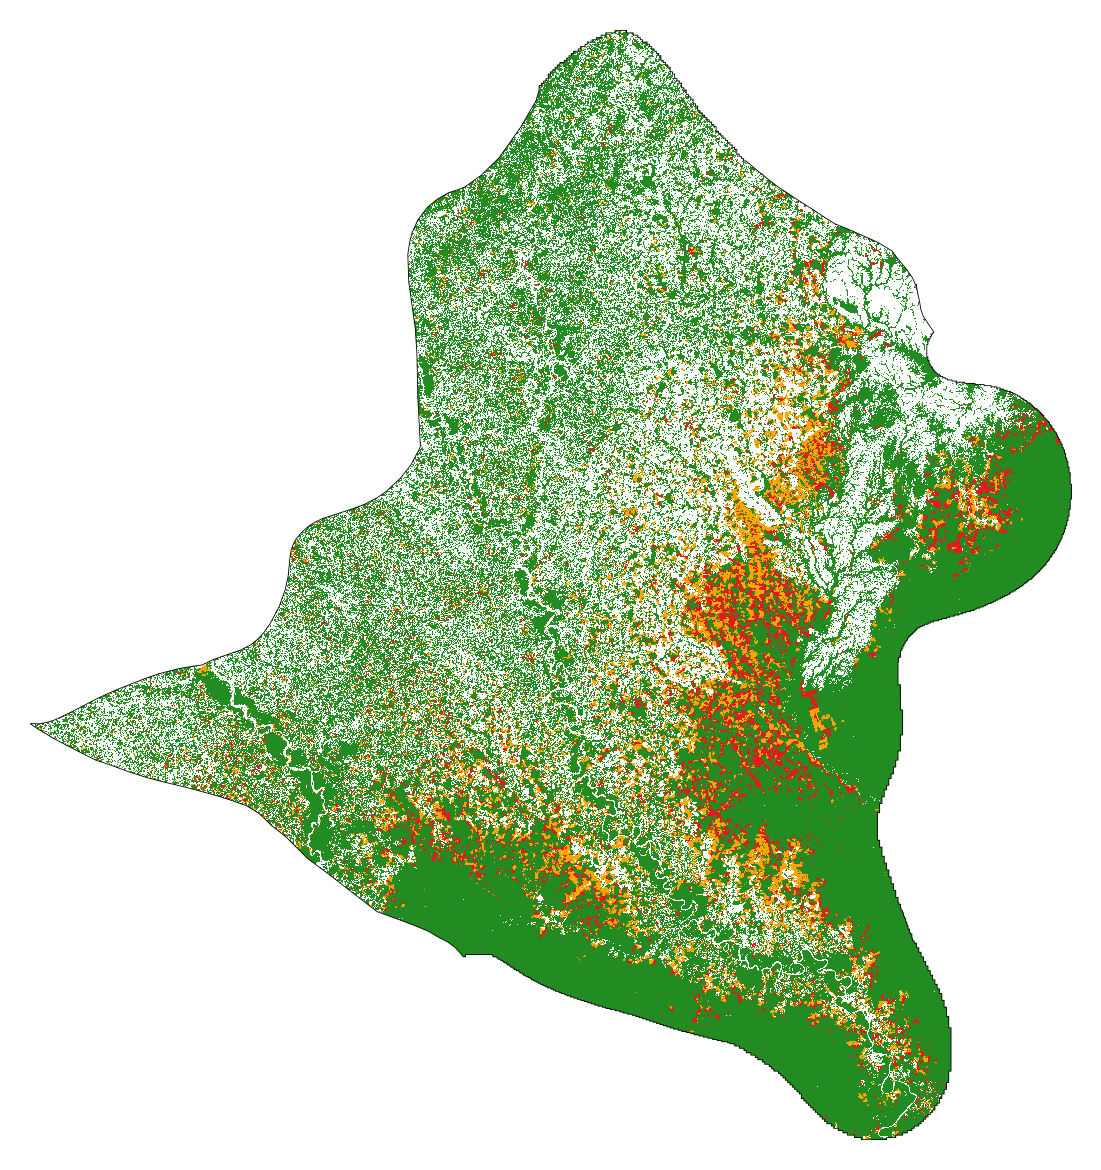

In [36]:
fcc_plot = os.path.join(plots_folder, "fcc123.png")
fig_fcc123 = rmj.plot.fcc123(
    input_fcc_raster=forest_change_file,
    maxpixels=1e8,
    output_file=fcc_plot,
    borders=aoi_vector,
    linewidth=0.2,
    figsize=(5, 4),
    dpi=300,
)


In [37]:
def calculate_period_plot_risk_map(
    period_dictionary, aoi_vector, model_folder, plots_folder
):
    period_output_folder = model_folder / period_dictionary["period"]
    ifile = str(period_output_folder / f"prob_bm_{period_dictionary['period']}.tif")
    ofile = str(plots_folder / f"prob_bm_{period_dictionary['period']}.png")
    riskmap_fig = rmj.benchmark.plot.vulnerability_map(
        input_map=ifile,
        maxpixels=1e8,
        output_file=ofile,
        borders=aoi_vector,
        legend=True,
        figsize=(6, 5),
        dpi=300,
        linewidth=0.3,
    )


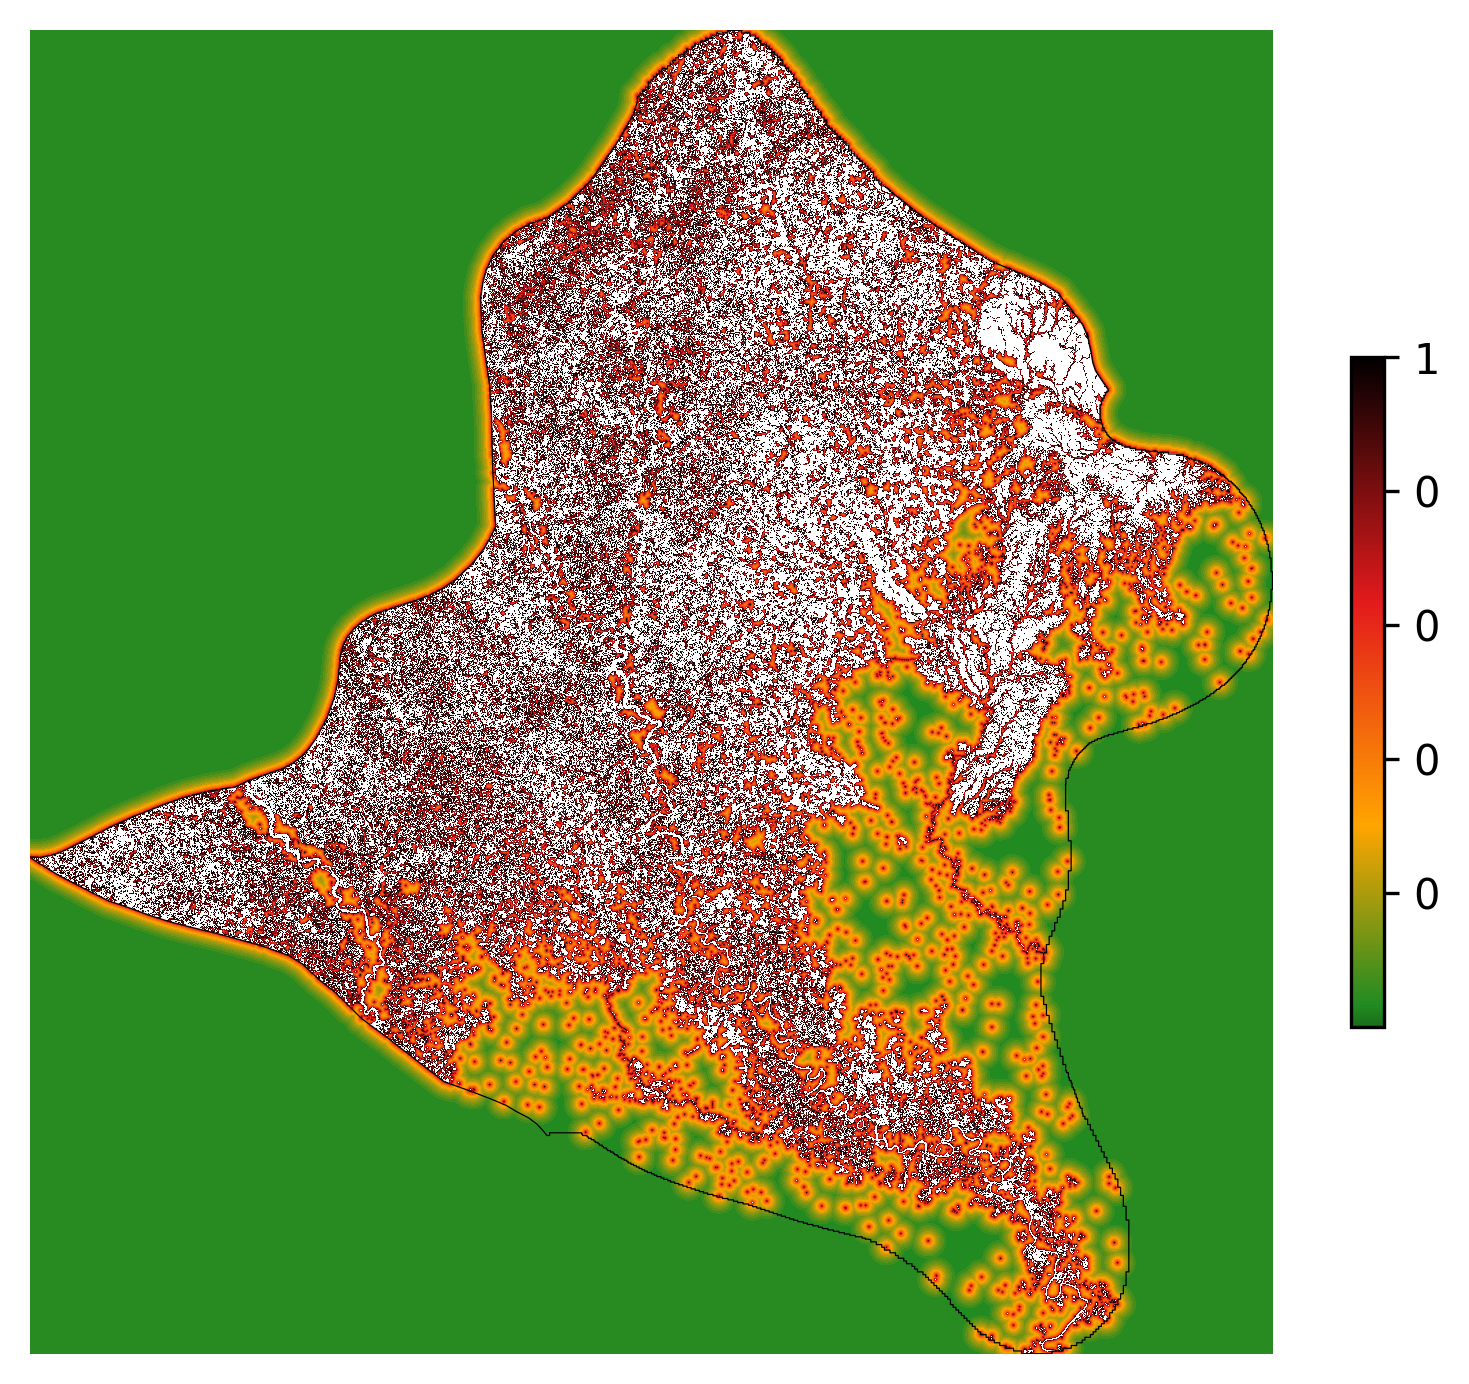

In [38]:
calculate_period_plot_risk_map(calibration_dict, aoi_vector, rmj_bm, plots_folder)


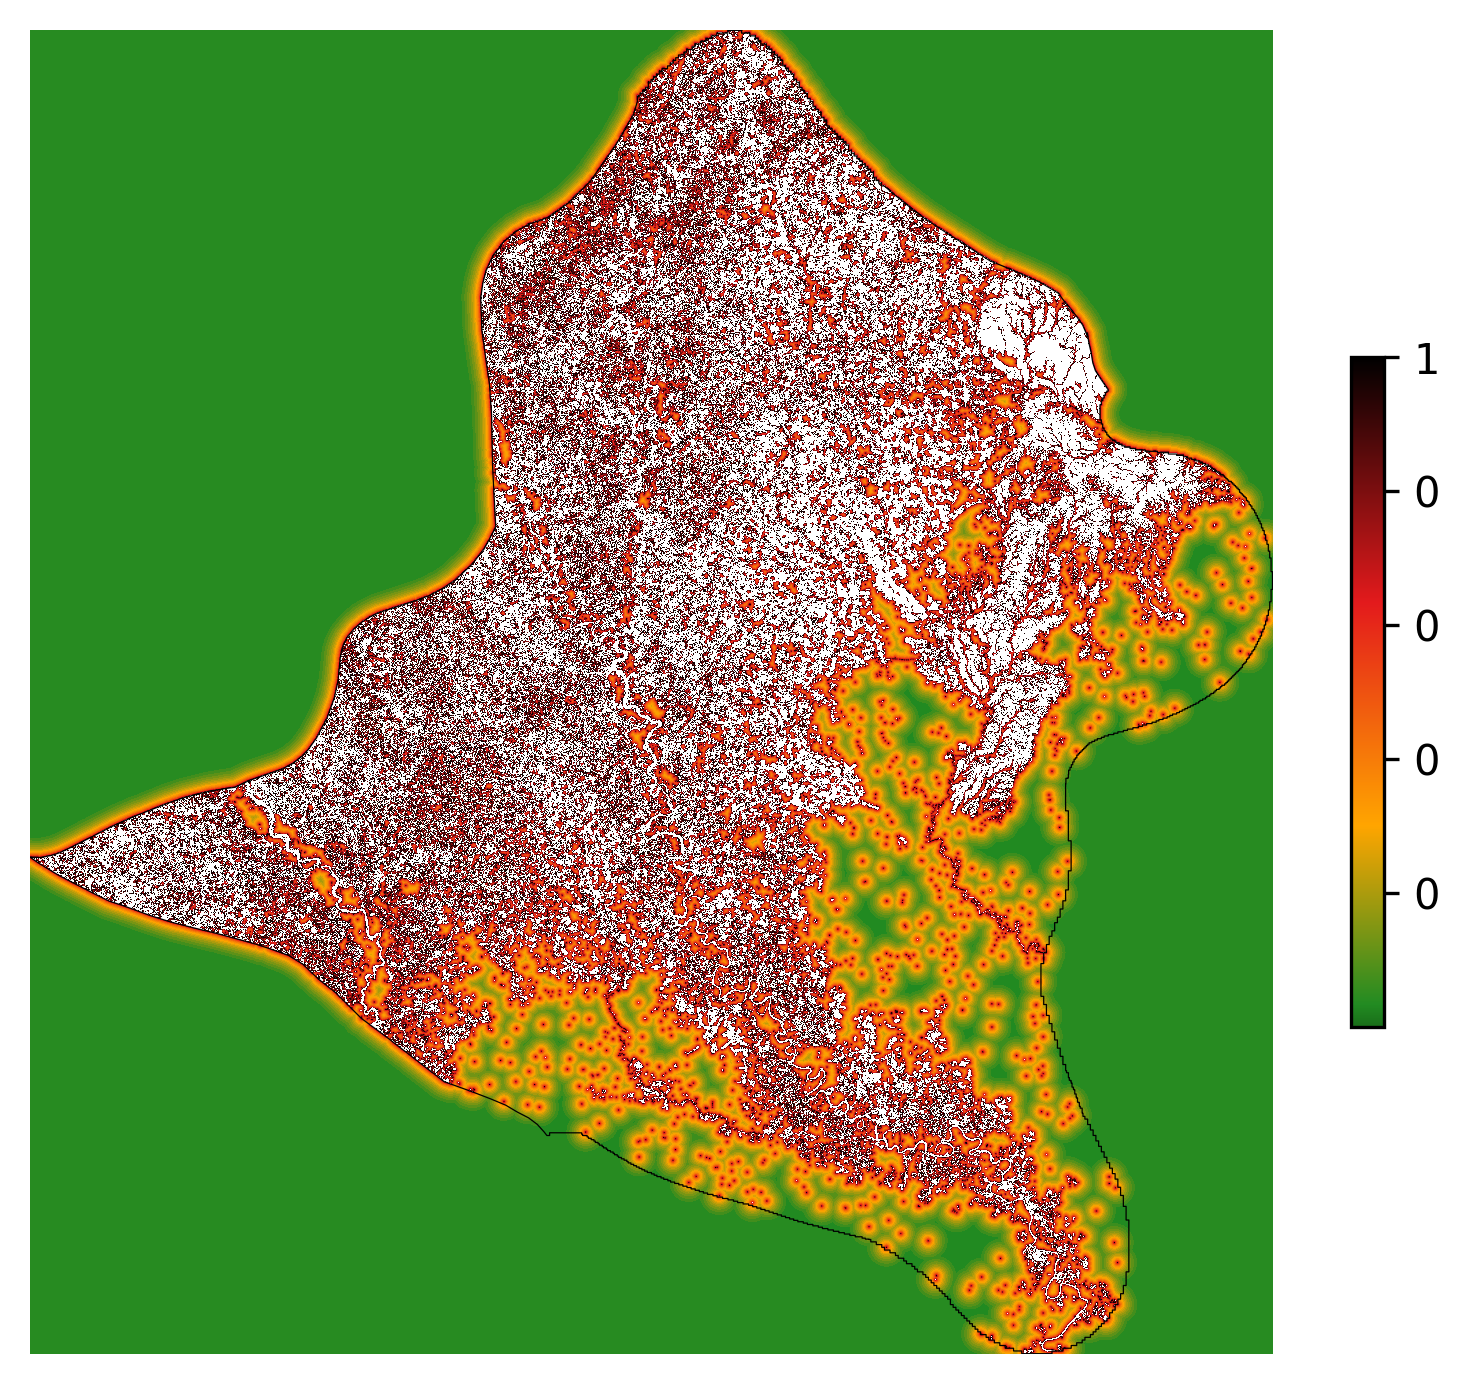

In [39]:
calculate_period_plot_risk_map(historical_dict, aoi_vector, rmj_bm, plots_folder)


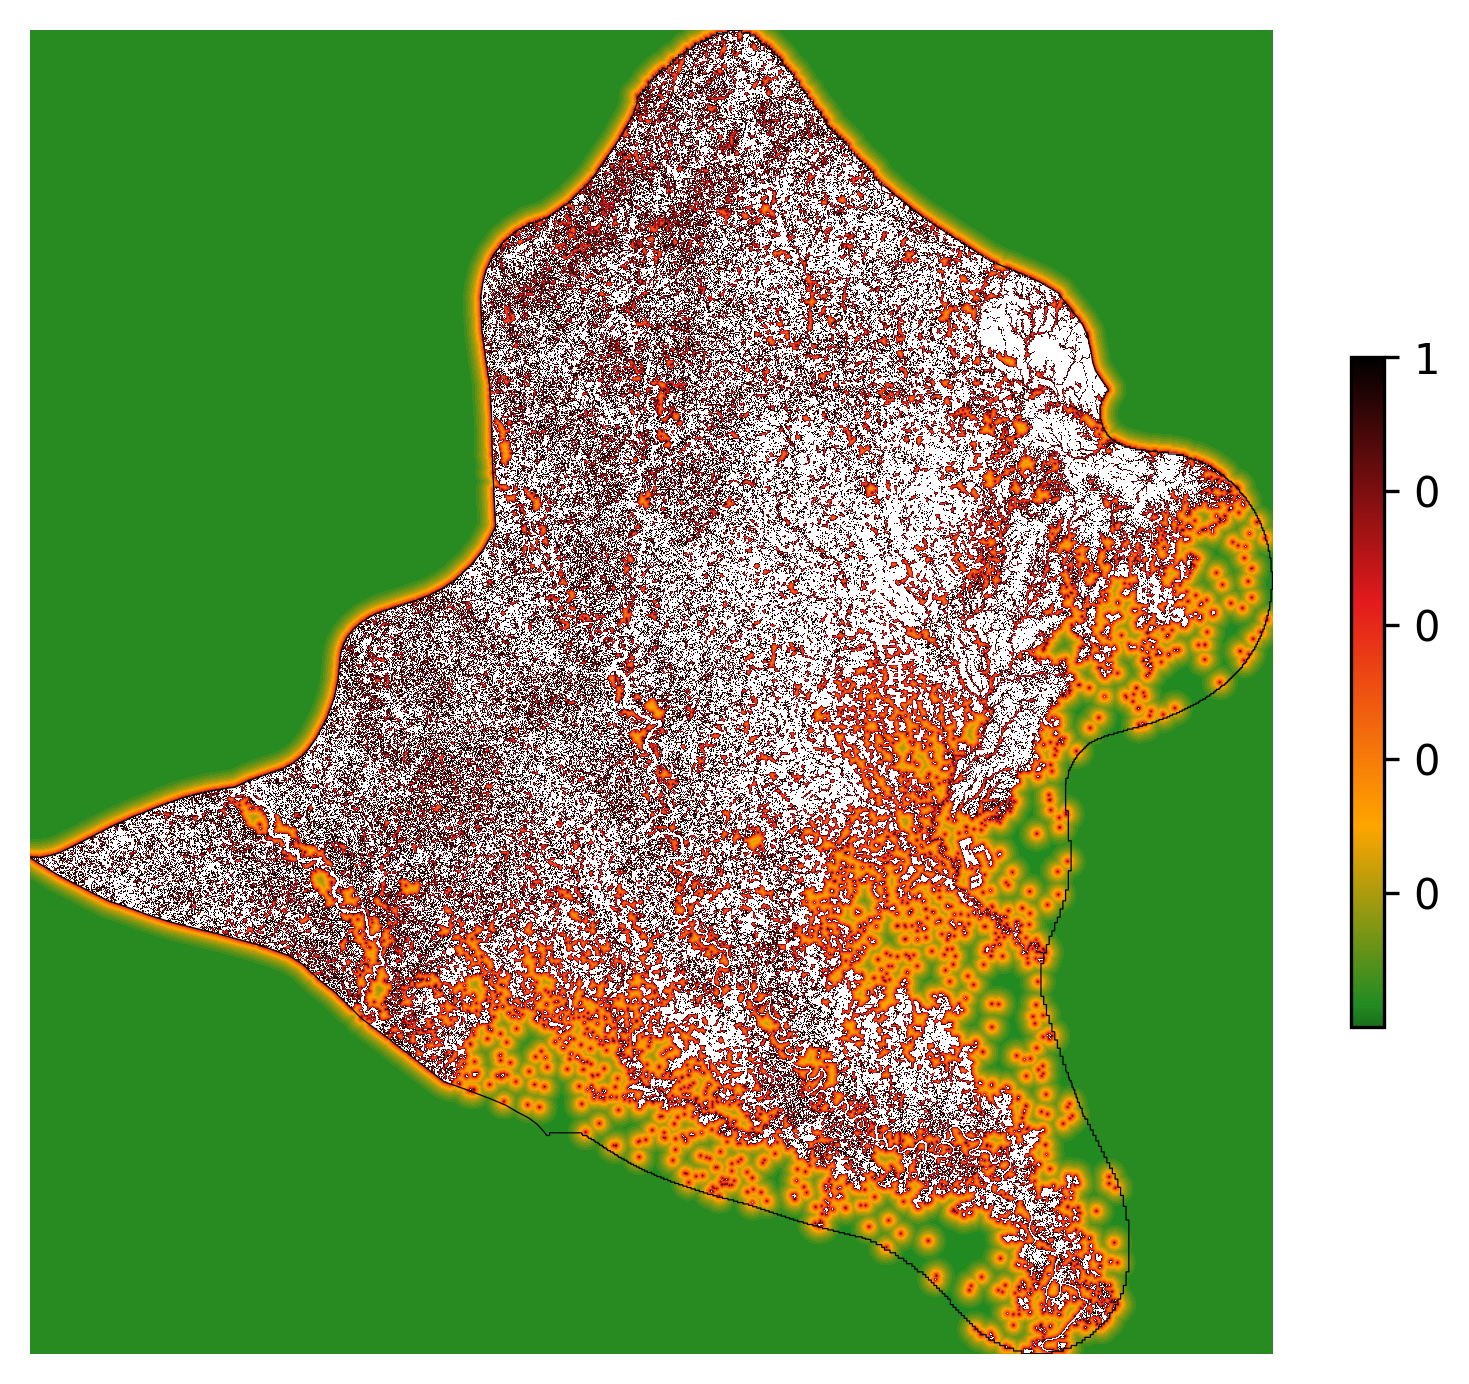

In [40]:
calculate_period_plot_risk_map(validation_dict, aoi_vector, rmj_bm, plots_folder)


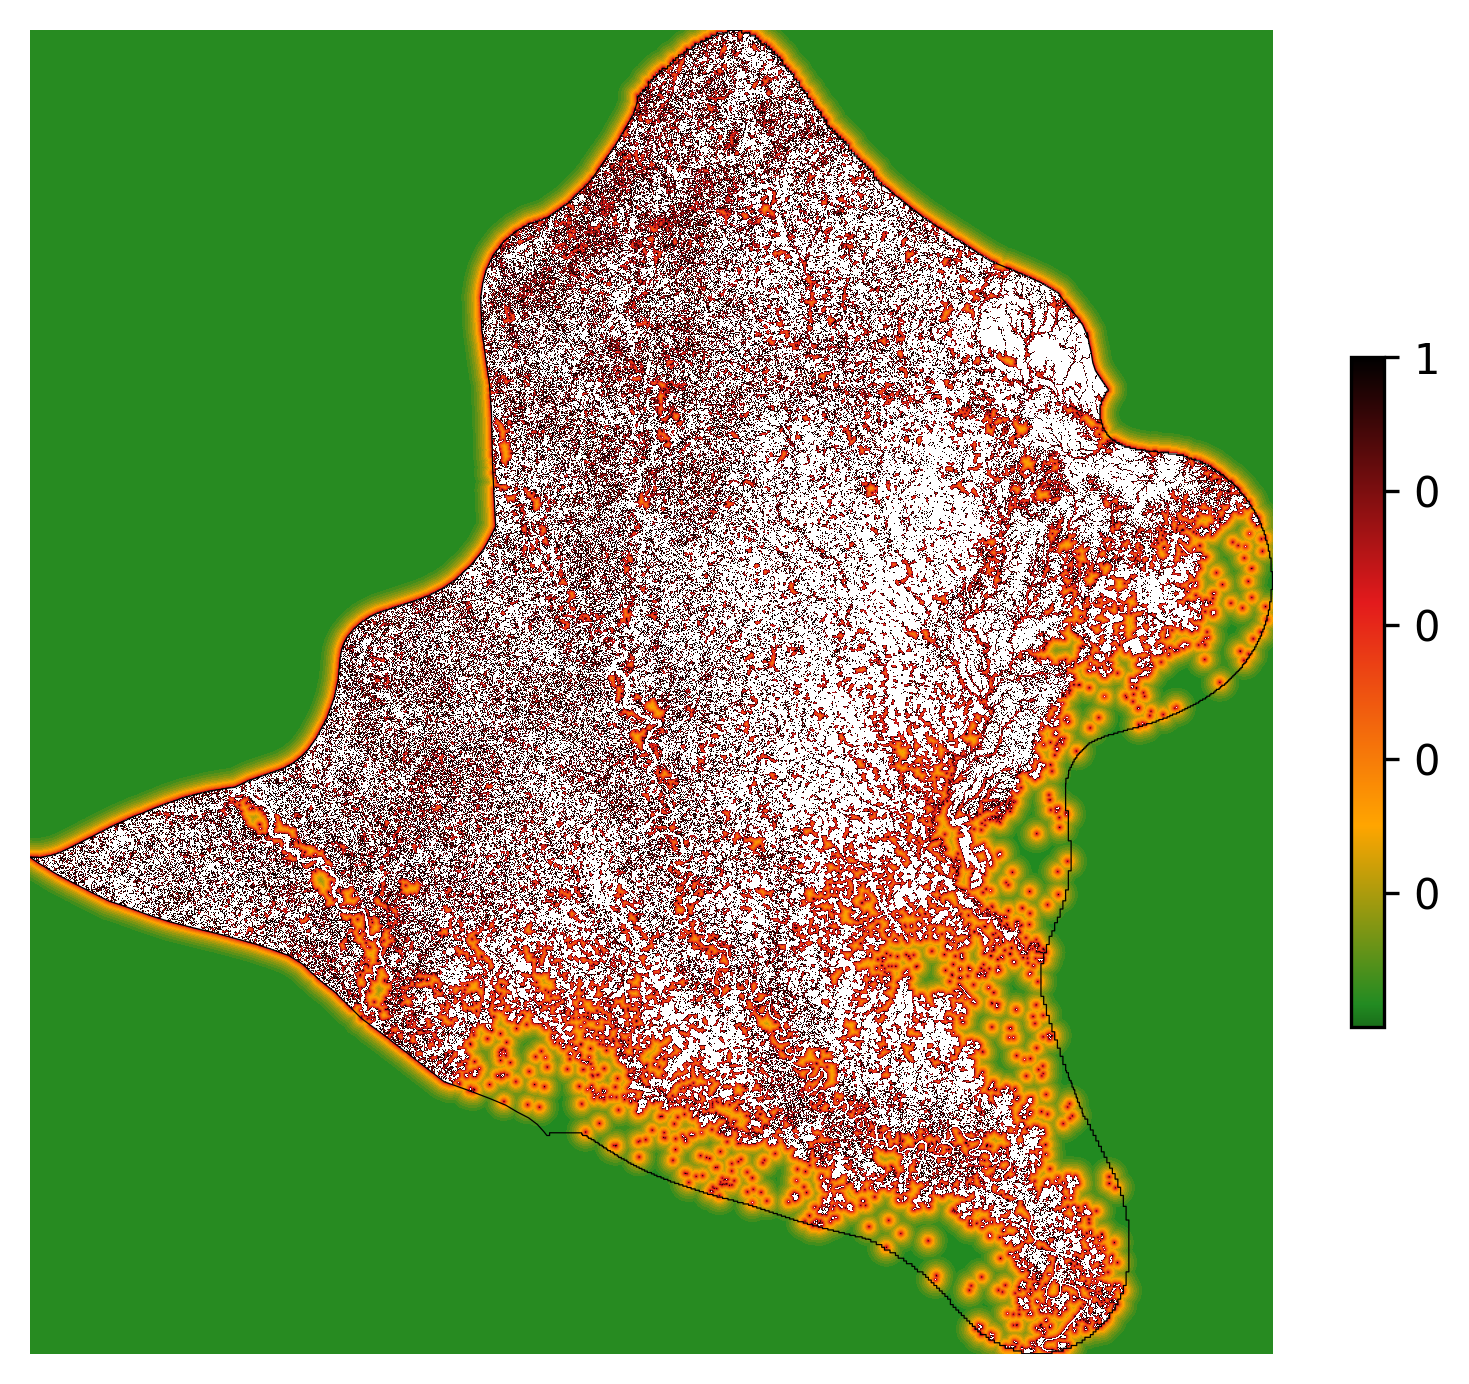

In [41]:
calculate_period_plot_risk_map(forecast_dict, aoi_vector, rmj_bm, plots_folder)
